# Importing Data

In [595]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs

from scipy.optimize import curve_fit



In [596]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')

df_abra = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Abra.xlsx', sheet_name='Sheet1')

df_copy = df.copy()

In [597]:
df_copy = df_copy[df_copy['Sample type'] == 'Spring water']    

In [598]:
# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000

# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']
df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000
df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']



df_copy['Si_mol/l'] = df_copy['Si_mM'] / 1000
df_copy['Si_uM'] = df_copy['Si_mM'] * 1000  
df_copy['Na_uM'] = df_copy['Na_mM'] * 1000
df_copy['Ca_uM'] = df_copy['Ca_mM'] * 1000
df_copy['Cl_uM'] = df_copy['Cl_mM'] * 1000

In [599]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_copy["Traverse"] = df_copy["GNS"].apply(assign_traverse)


In [600]:
df_copy = df_copy[df_copy['Traverse'] == 'Traverse 3']

# Calculate distance for Abra samples for their longitude. Do longitude 85.5984 minus the longitude of the sample. Then convert to meters to give a new 'x' column
df_copy['x'] = (85.5984 - df_copy['Longitude']) * 111000

# calculate elevation difference between df_abra['Elevation'] and the elevation of the ridge
df_copy['y'] = 2600 - df_copy['Elevation']

df_copy['x+y'] = df_copy['x'] + df_copy['y']

# calculate sqrt(x^2 + y^2) for each sample
df_copy['distance_from_ridge'] = np.sqrt(df_copy['x']**2 + df_copy['y']**2)

df_copy['2(x+y)'] = 2 * df_copy['x+y']


# print x+y, distance from ridge and 2(x+y)
#print(df_copy[['x+y', 'distance_from_ridge', '2(x+y)', 'Sample ID']])

In [601]:
# Initialize a dictionary to store h distributions
h_distributions = {}

# Loop through each sample to calculate the h range
for index, row in df_copy.iterrows():
    sample_id = row['Sample ID']  # Assuming 'Sample ID' uniquely identifies each sample
    # Generate 1000 evenly spaced h values for the sample
    h_values = np.linspace(row['distance_from_ridge'], row['2(x+y)'], 1000)
    # Store in the dictionary
    h_distributions[sample_id] = h_values
    
    

In [ ]:
# Create a new column Sr_residuals where you take the 87Sr/86Sr ratio of the sample and subtract the one of the sample before it, but the samples are binned for elevation, so samples are sorted from highest to lowest elevation
df_copy2 = df_copy.copy()

# Sort by Elevation in descending order
df_copy2 = df_copy2.sort_values(by='Elevation', ascending=False)

# Calculate residuals for Sr isotopes
df_copy2['Sr_residuals'] = df_copy2['Sr87/Sr86'].diff()

# Display the resulting DataFrame
print(df)

# Modelling

In [602]:
variable = 'Si_uM'

# define Co
C_zero = df_copy[variable].min()
C_max = df_copy[variable].max()

C_eq = C_max

# Cmax we have is greater than C_eq they have. Threfore we wil set our Cmax as C_eq. Is this valid???


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

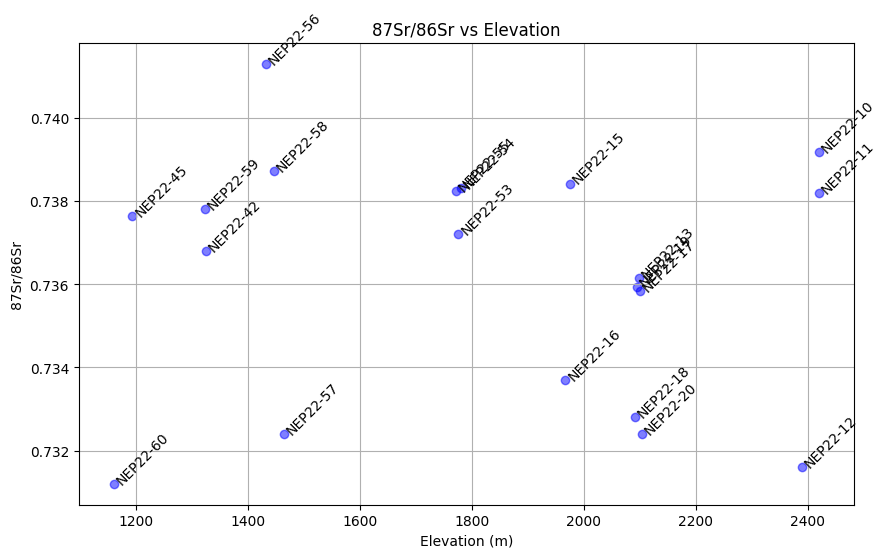

In [603]:
# plot 87Sr/86Sr against Elevation
plt.figure(figsize=(10, 6))
plt.scatter(df_copy['Elevation'], df_copy['Sr87/Sr86'], c='blue', alpha=0.5)
plt.xlabel('Elevation (m)')
plt.ylabel('87Sr/86Sr')
for index, row in df_copy.iterrows():
    plt.text(row['Elevation'], row['Sr87/Sr86'], row['Sample ID'], rotation=45)
plt.title('87Sr/86Sr vs Elevation')
plt.grid(True)  
plt.show()


In [604]:
# Removing things affected by river, or outliers:
# remove Nep23-116
df_copy = df_copy[df_copy['Sample ID'] != 'Nep23-116']

#remove samples with GNS that start with S3a, S3b, S3c, S3d, S3e, S3f 
df_copy = df_copy[~df_copy['GNS'].str.contains('S3a(?!b|c)')]
df_copy = df_copy[~df_copy['GNS'].str.contains('S3b')]
df_copy = df_copy[~df_copy['GNS'].str.contains('S3c')]
df_copy = df_copy[~df_copy['GNS'].str.contains('S3d')]
df_copy = df_copy[~df_copy['GNS'].str.contains('S3e')]
df_copy = df_copy[~df_copy['GNS'].str.contains('S3f')]

posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


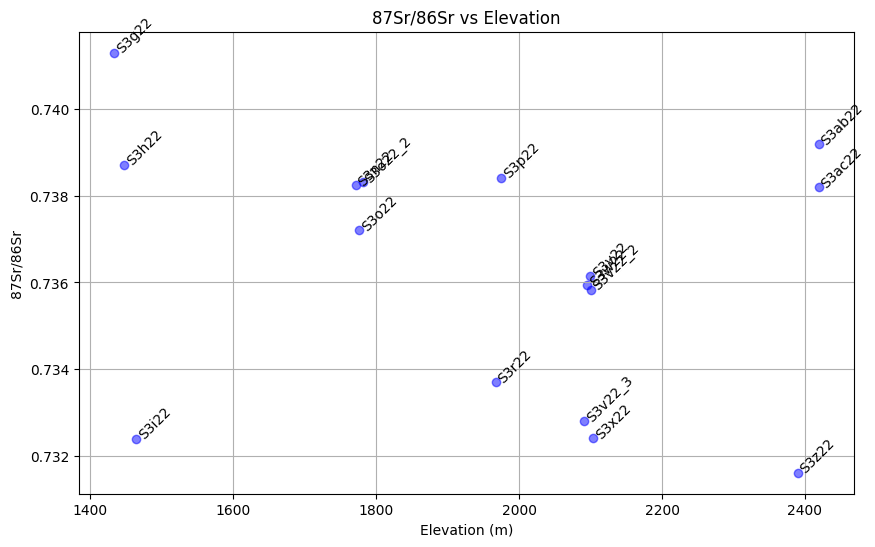

In [605]:
# plot 87Sr/86Sr against Elevation
plt.figure(figsize=(10, 6))
plt.scatter(df_copy['Elevation'], df_copy['Sr87/Sr86'], c='blue', alpha=0.5)
plt.xlabel('Elevation (m)')
plt.ylabel('87Sr/86Sr')
for index, row in df_copy.iterrows():
    plt.text(row['Elevation'], row['Sr87/Sr86'], row['GNS'], rotation=45)
plt.title('87Sr/86Sr vs Elevation')
plt.grid(True)  
plt.show()


In [544]:
# ##### USING BRANTLEY AND WHITE EQUATION FOR T


# # Constants
# C_zero = df_copy[variable].min()  # Ensure `variable` exists and is numeric
# C_max = df_copy[variable].max()
# C_eq = C_max*2

# tau = np.exp(2)
# phi = 0.15
# rho_min = 2.67  # g/cm^3
# rho_sf = 1000 * rho_min / phi  # g/L
# A_surf = 0.1
# x_r = 0.36
# f_w = 1  # approximately

# # Calculate B
# B = tau * rho_sf * A_surf * x_r * f_w * phi * (3.1 * 10**-7)

# # Empty list for time results
# times = []

# for index, row in df_copy.iterrows():
#     try:
#         # Calculate numerator and denominator
#         numerator = (C_eq / B) * (row[variable] - C_zero)
#         denominator = (C_eq - row[variable])
        
#         # Ensure denominator is not zero or negative
#         if denominator <= 0 or numerator <= 0:
#             time = np.nan  # Invalid result
#         else:
#             time = (numerator / denominator) ** (1 / 0.39)
        
#         times.append(time)
#         print(f"Index: {index}, Time: {time}")
    
#     except Exception as e:
#         print(f"Error at index {index}: {e}")
#         times.append(np.nan)

# # Add the `time` column to the dataframe
# df_copy['time'] = times

In [591]:
# USING A FIXED RATE CONSTANT K


# Constants
C_zero = df_copy[variable].min()  # Ensure `variable` exists and is numeric
C_max = df_copy[variable].max()
C_eq = C_max

tau = np.exp(2)
phi = 0.15
rho_min = 2.67  # g/cm^3
rho_sf = 1000 * rho_min / phi  # g/L
A_surf = 0.1
x_r = 0.36
f_w = 1  # approximately

# Fixed k value
k_fixed = 8.7 * 10**-6 * 10**6 # to get from mol/m^2/year to umol/m^2/year

# Calculate R
R = rho_sf * k_fixed * A_surf * x_r

# Empty list for time results
times = []

for index, row in df_copy.iterrows():
    try:
        # Calculate D
        C = row[variable]
        if C == C_eq:  # Prevent division by zero
            times.append(np.nan)
            continue

        D = (C_zero - C) / (C - C_eq)
        
        # Solve for t
        if D <= 0:
            time = np.nan  # Invalid D value
        else:
            time = (D * C_eq) / (tau * phi * R * f_w)
        
        times.append(time)
        #print(f"Index: {index}, Time: {time}")
    
    except Exception as e:
        #print(f"Error at index {index}: {e}")
        times.append(np.nan)

# Add the `time` column to the dataframe
df_copy['time'] = times




In [592]:
print(df_copy['time'])



85     0.011974
86     0.019610
87     0.004383
88     0.007158
90     0.026950
91     0.004876
92     0.006870
93     0.038210
94     0.007563
96          NaN
125    0.051500
126    0.044951
127    0.043267
128    0.231730
129         NaN
130    0.147306
187    0.211304
188    0.114236
190    0.008639
191    0.010016
217    0.007066
219    0.029345
221    0.013681
222    0.069952
223    0.333625
Name: time, dtype: float64


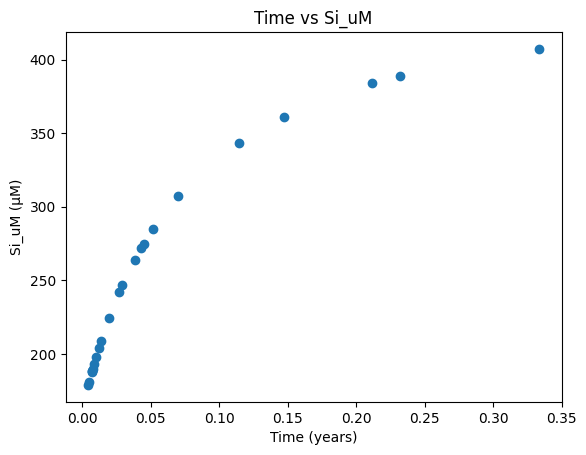

In [593]:
# plot time against concentration on the y
plt.scatter(df_copy['time'], df_copy[variable])
plt.xlabel('Time (years)')
plt.ylabel(f'{variable} (μM)')
plt.title(f'Time vs {variable}')
plt.show()

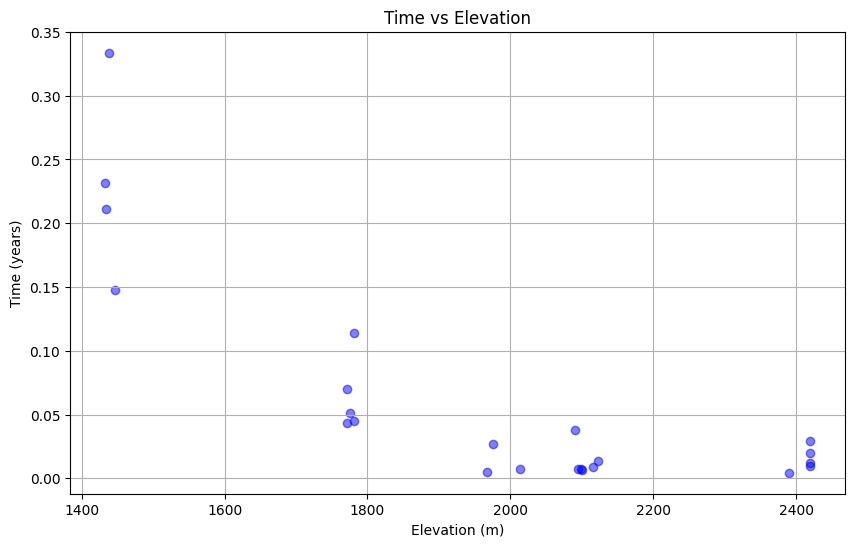

In [594]:
# plot time against latitude on the x
plt.figure(figsize=(10, 6))
plt.scatter(df_copy['Elevation'], df_copy['time'], c='blue', alpha=0.5)
plt.xlabel('Elevation (m)')
plt.ylabel('Time (years)')
plt.title('Time vs Elevation')
plt.grid(True)
plt.show()


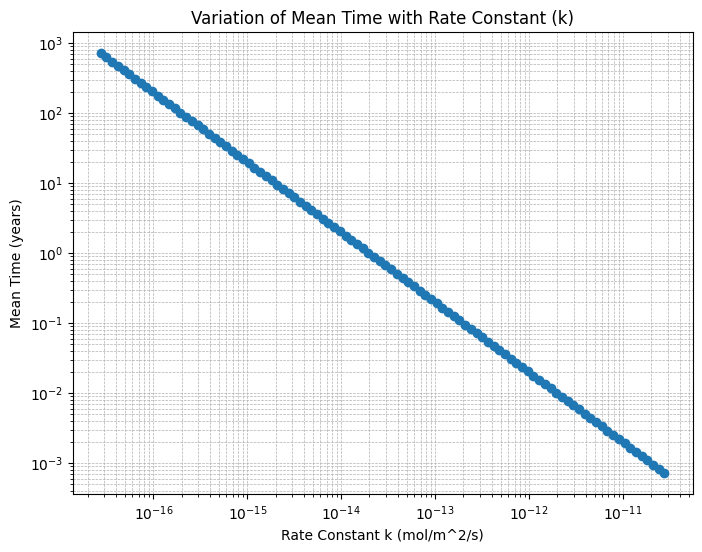

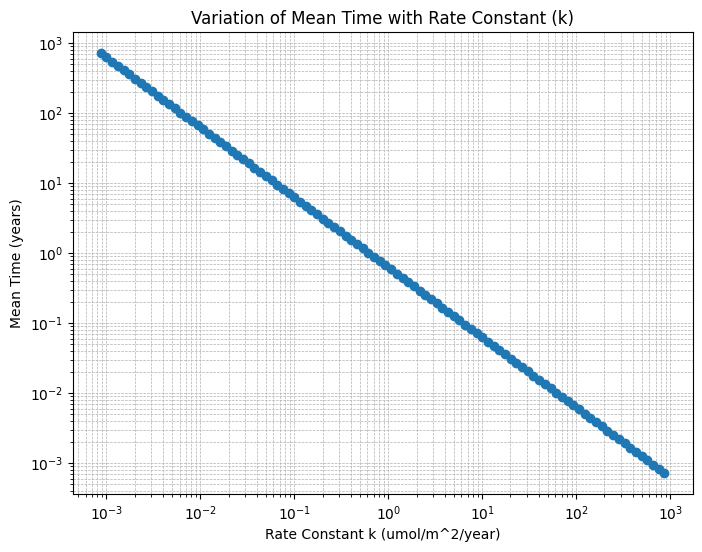

In [549]:
##### VARY FIXED K TO GET TIME VS K


# Fixed base k value
k_base = 8.7 * 10**-6 * 10**6  # Base k value in umol/m^2/year

# Generate a dictionary of k values from 0.01x to 100x the base value
k_range = np.logspace(-4, 2, 100) * k_base
k_dict = {f"k_{i}": k for i, k in enumerate(k_range)}

# Placeholder for k vs. average time results
k_vs_time = []

# Iterate over k values and compute mean times for each
for k_label, k_fixed in k_dict.items():
    # Recalculate R for the current k value
    R = rho_sf * k_fixed * A_surf * x_r

    # Calculate times for the current k value
    times = []
    for _, row in df_copy.iterrows():
        try:
            # Calculate D
            C = row[variable]
            if C == C_eq:  # Prevent division by zero
                times.append(np.nan)
                continue

            D = (C_zero - C) / (C - C_eq)

            # Solve for t
            if D <= 0:
                time = np.nan  # Invalid D value
            else:
                time = (D * C_eq) / (tau * phi * R * f_w)

            times.append(time)

        except Exception:
            times.append(np.nan)

    # Store the mean time for the current k value
    mean_time = np.nanmean(times)  # Ignore NaNs when calculating mean
    k_vs_time.append((k_fixed, mean_time))

# Convert results to a DataFrame for plotting
k_time_df = pd.DataFrame(k_vs_time, columns=["k", "mean_time"])

# convert k to mol/m^2/second
k_time_df['k_mol_m2_s'] = k_time_df['k'] * 3.1688*10**-14

# Plot k vs. mean time
plt.figure(figsize=(8, 6))
plt.plot(k_time_df["k_mol_m2_s"], k_time_df["mean_time"], marker='o', linestyle='-')
plt.xscale('log')  # Logarithmic scale for k
plt.yscale('log')  # Logarithmic scale for time
plt.xlabel("Rate Constant k (mol/m^2/s)")
plt.ylabel("Mean Time (years)")
plt.title("Variation of Mean Time with Rate Constant (k)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Plot k vs. mean time
plt.figure(figsize=(8, 6))
plt.plot(k_time_df["k"], k_time_df["mean_time"], marker='o', linestyle='-')
plt.xscale('log')  # Logarithmic scale for k
plt.yscale('log')  # Logarithmic scale for time
plt.xlabel("Rate Constant k (umol/m^2/year)")
plt.ylabel("Mean Time (years)")
plt.title("Variation of Mean Time with Rate Constant (k)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [550]:
# print what k values correspond to 50, 25, 10, 5 years
years = [50, 25, 10, 5]
for year in years:
    # Find the k value closest to the target year
    target_time = year
    closest_time = k_time_df.iloc[(k_time_df["mean_time"] - target_time).abs().argsort()[:1]]

    
    print(f"Closest k value to {target_time} years: {closest_time['k_mol_m2_s'].values[0]:.2e} mol/m ^2/s")
    
print('\n')
# print what k values correspond to 50, 25, 10, 5 years
years = [50, 25, 10, 5]
for year in years:
    # Find the k value closest to the target year
    target_time = year
    closest_time = k_time_df.iloc[(k_time_df["mean_time"] - target_time).abs().argsort()[:1]]

    
    print(f"Closest k value to {target_time} years: {closest_time['k'].values[0]:.2e} umol/m ^2/year")

Closest k value to 50 years: 3.91e-16 mol/m ^2/s
Closest k value to 25 years: 7.85e-16 mol/m ^2/s
Closest k value to 10 years: 2.09e-15 mol/m ^2/s
Closest k value to 5 years: 4.19e-15 mol/m ^2/s


Closest k value to 50 years: 1.23e-02 umol/m ^2/year
Closest k value to 25 years: 2.48e-02 umol/m ^2/year
Closest k value to 10 years: 6.58e-02 umol/m ^2/year
Closest k value to 5 years: 1.32e-01 umol/m ^2/year


In [551]:
df_copy['Ca_uM'] = df_copy['Ca_mM'] * 1000
df_copy['Sr_uM'] = df_copy['Sr_mM'] * 1000
df_copy['Mg_uM'] = df_copy['Mg_mM'] * 1000
df_copy['Si_uM'] = df_copy['Si_mM'] * 1000
df_copy['Na_uM'] = df_copy['Na_mM'] * 1000
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000
df_copy['K_uM'] = df_copy['K_mM'] * 1000
df_copy['Al_uM'] = df_copy['Al_mM'] * 1000
df_copy['Cl_uM'] = df_copy['Cl_mM'] * 1000

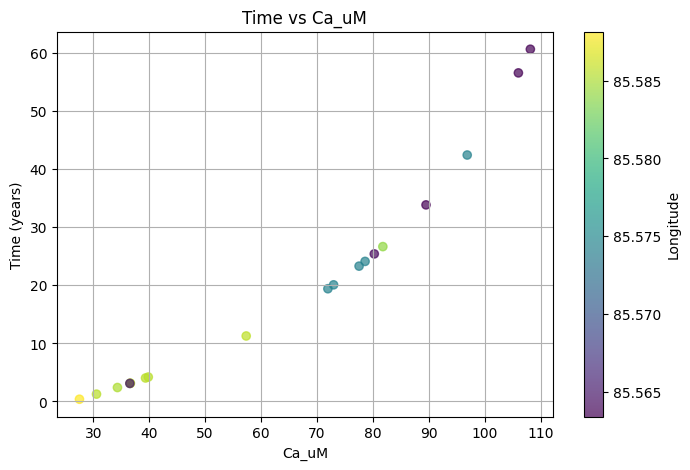

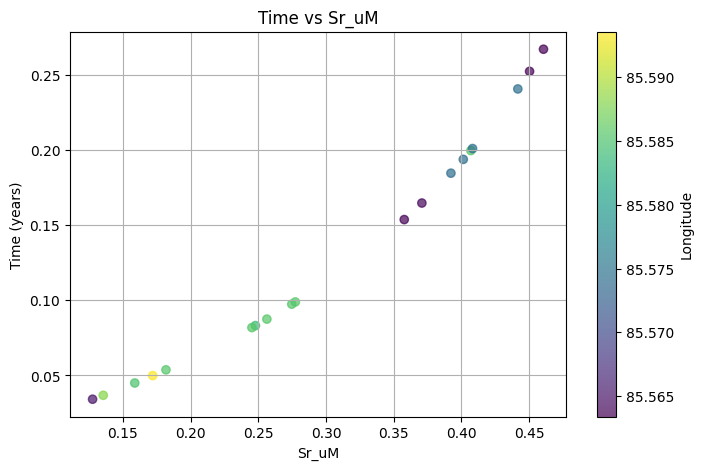

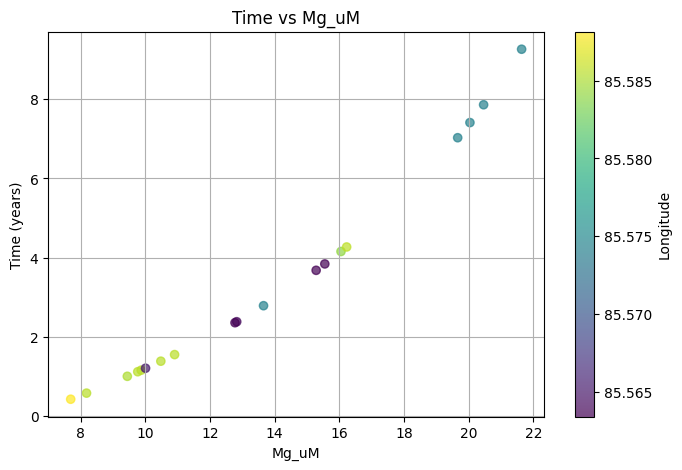

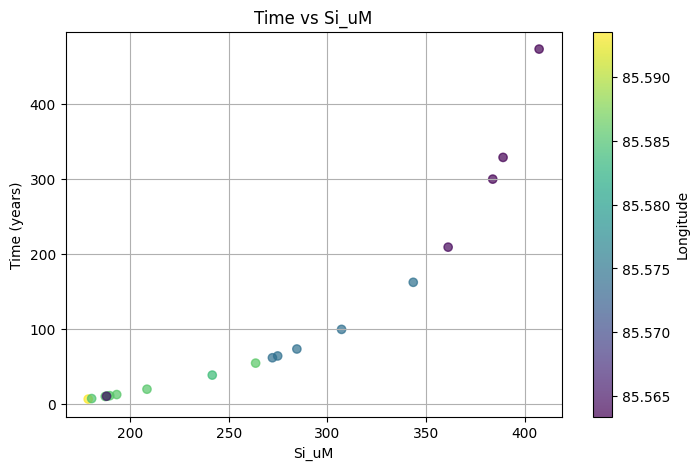

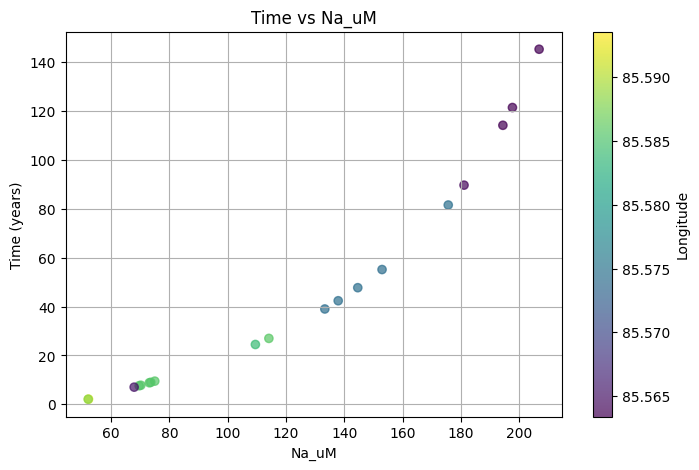

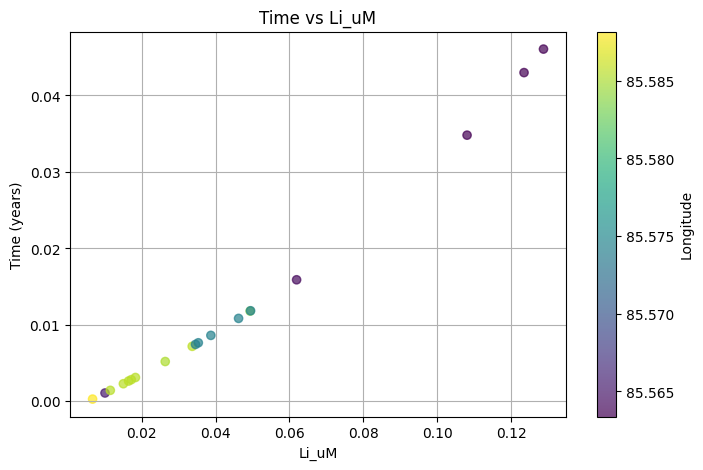

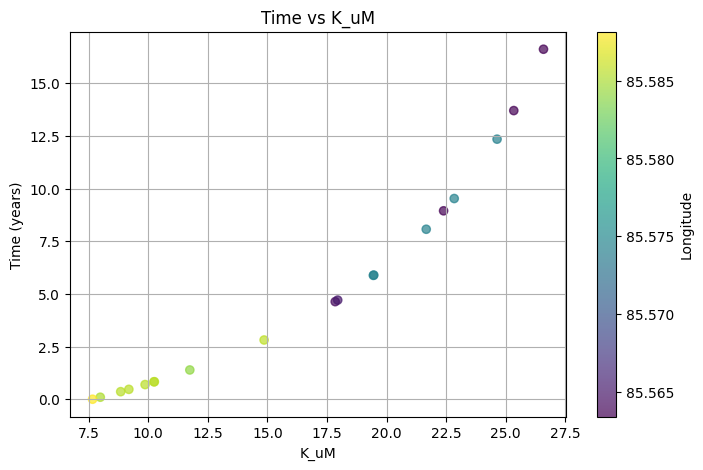

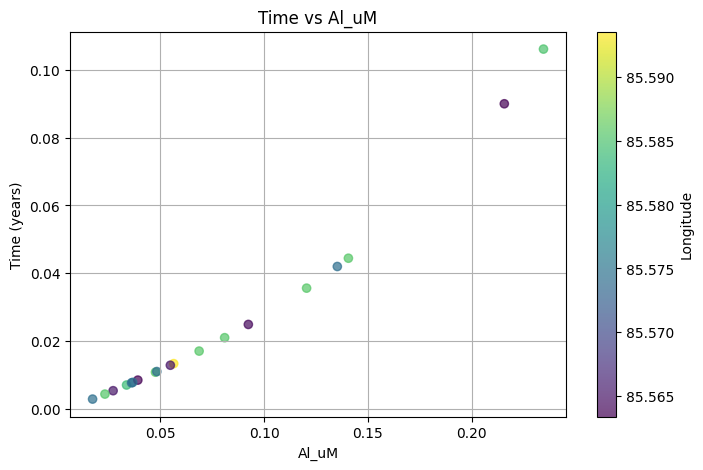

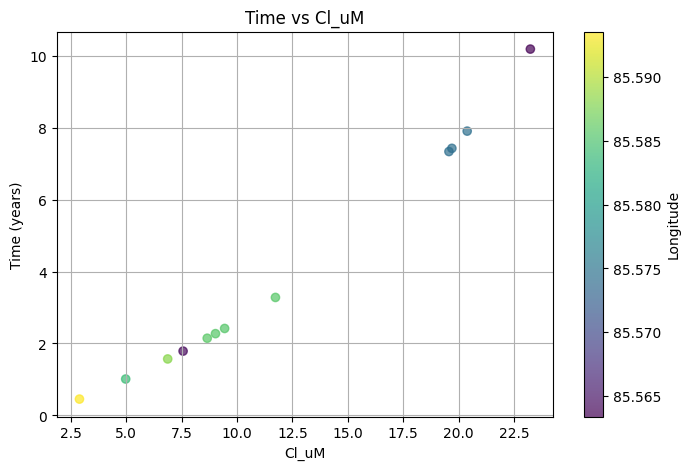

In [565]:
# List of variables to process and plot
variables = ['Ca_uM', 'Sr_uM', 'Mg_uM', 'Si_uM', 'Na_uM', 'Li_uM', 'K_uM', 'Al_uM', 'Cl_uM']

# Placeholder to store results for validation or further analysis
time_results = {}

for variable in variables:
    # Ensure the variable exists and is numeric
    if variable in df_copy.columns and np.issubdtype(df_copy[variable].dtype, np.number):
        # Constants
        C_zero = df_copy[variable].min()
        C_max = df_copy[variable].max()
        C_eq = C_max
        tau = np.exp(2)
        phi = 0.15
        rho_min = 2.67  # g/cm^3
        rho_sf = 1000 * rho_min / phi  # g/L
        A_surf = 0.1
        x_r = 0.36
        f_w = 1  # approximately

        # Fixed k value
        #k_fixed = 8.7 * 10**-6 * 10**6  # to get from mol/m^2/year to umol/m^2/year
        k_fixed = 6.14e-03
        # Calculate R
        R = rho_sf * k_fixed * A_surf * x_r

        # Empty list for time results
        times = []

        for index, row in df_copy.iterrows():
            try:
                # Calculate D
                C = row[variable]
                if C == C_eq:  # Prevent division by zero
                    times.append(np.nan)
                    continue

                D = (C_zero - C) / (C - C_eq)

                # Solve for t
                if D <= 0:
                    time = np.nan  # Invalid D value
                else:
                    time = (D * C_eq) / (tau * phi * R * f_w)

                times.append(time)
            except Exception as e:
                times.append(np.nan)

        # Add the `time` column to the dataframe
        df_copy[f'{variable}_time'] = times
        time_results[variable] = times

        # Plot the variable against time
        plt.figure(figsize=(8, 5))
        plt.scatter(df_copy['Elevation'], df_copy[f'{variable}_time'], alpha=0.7)
        for i, txt in enumerate(df_copy['GNS']):
            plt.annotate(txt, (df_copy['Elevation'].iloc[i], df_copy[f'{variable}_time'].iloc[i]))
        plt.title('Time vs Elevation - ' + variable)
        plt.ylabel('Time (years)')
        #plt.yscale('log')
        plt.xlabel('Elevation (m)')
        plt.grid(True)
        #plt.show()
        plt.close()
        
        # Plot the variable against time
        plt.figure(figsize=(8, 5))
        scatter = plt.scatter(df_copy[variable], df_copy[f'{variable}_time'], c=df_copy['Longitude'], cmap='viridis', alpha=0.7)
        # for i, txt in enumerate(df_copy['GNS']):
        #     plt.annotate(txt, (df_copy[variable].iloc[i], df_copy[f'{variable}_time'].iloc[i]))
        plt.title('Time vs ' + variable)
        plt.ylabel('Time (years)')
        #plt.yscale('log')
        plt.xlabel(f'{variable}')
        plt.colorbar(scatter, label='Longitude')
        plt.grid(True)
        #plt.show()


# Fitting an Exponential

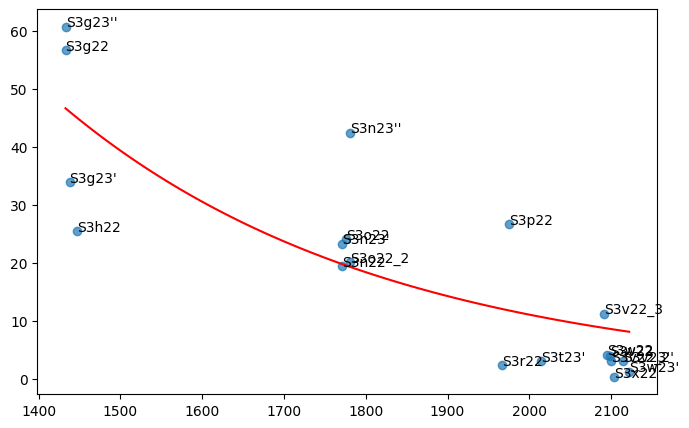

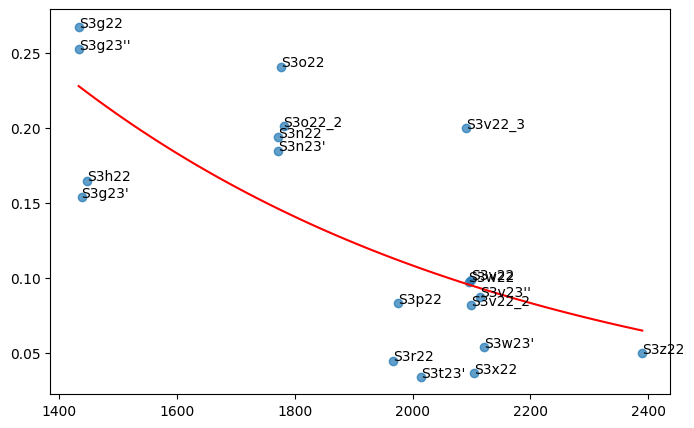

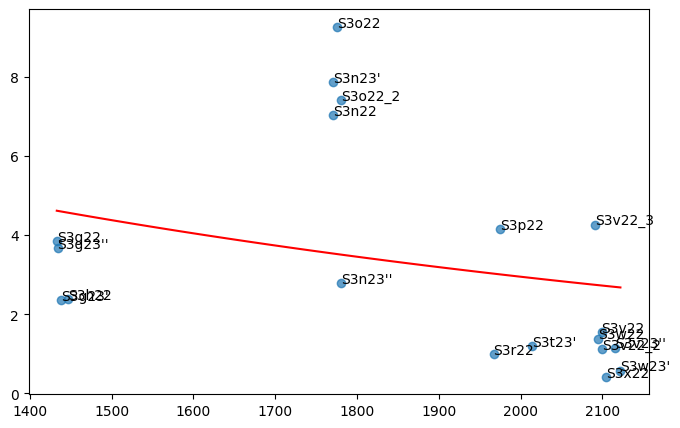

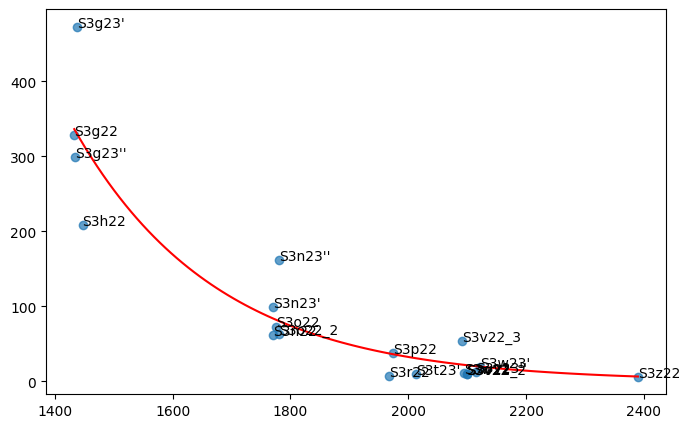

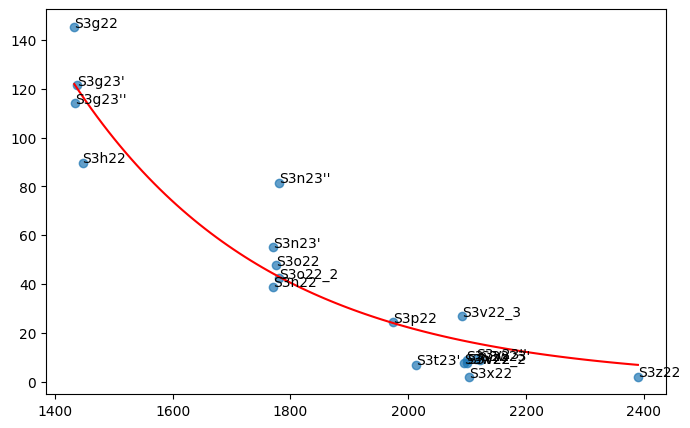

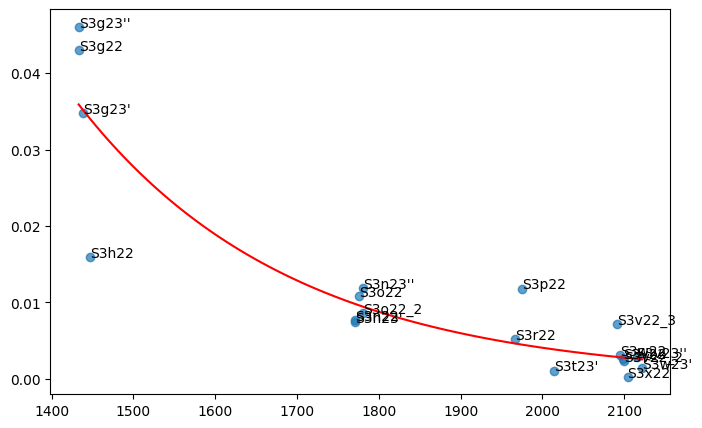

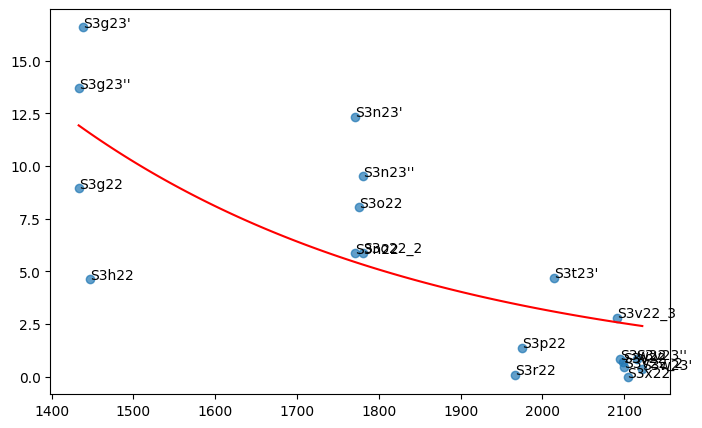

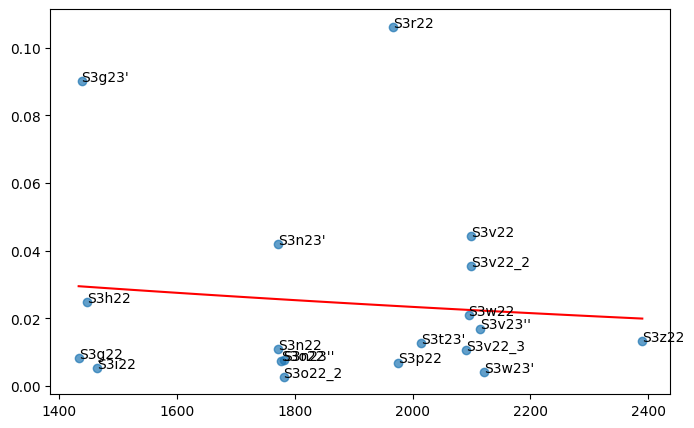

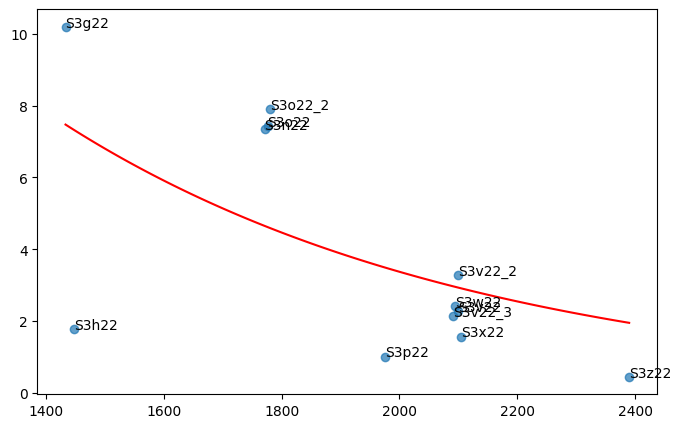

In [553]:
# Import necessary libraries
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Remove Nep23-116
df_copy = df_copy[df_copy['Sample ID'] != 'Nep23-116']

# Remove samples with GNS that start with S3a, S3b, S3c, S3d, S3e, S3f 
for prefix in ['S3a', 'S3b', 'S3c', 'S3d', 'S3e', 'S3f']:
    df_copy = df_copy[~df_copy['GNS'].str.contains(prefix)]

# List of variables to process and plot
variables = ['Ca_uM', 'Sr_uM', 'Mg_uM', 'Si_uM', 'Na_uM', 'Li_uM', 'K_uM', 'Al_uM', 'Cl_uM']

# Placeholder to store results for validation or further analysis
time_results = {}

# Function for exponential fit
def exponential_func(x, a, b):
    return a * np.exp(b * x)

for variable in variables:
    # Ensure the variable exists and is numeric
    if variable in df_copy.columns and np.issubdtype(df_copy[variable].dtype, np.number):
        # Constants
        C_zero = df_copy[variable].min()
        C_max = df_copy[variable].max()
        C_eq = C_max
        tau = np.exp(2)
        phi = 0.15
        rho_min = 2.67  # g/cm^3
        rho_sf = 1000 * rho_min / phi  # g/L
        A_surf = 0.1
        x_r = 0.36
        f_w = 1  # approximately

        # Fixed k value
        k_fixed = 6.14e-03
        # Calculate R
        R = rho_sf * k_fixed * A_surf * x_r

        # Empty list for time results
        times = []

        for index, row in df_copy.iterrows():
            try:
                # Calculate D
                C = row[variable]
                if C == C_eq:  # Prevent division by zero
                    times.append(np.nan)
                    continue

                D = (C_zero - C) / (C - C_eq)

                # Solve for t
                if D <= 0:
                    time = np.nan  # Invalid D value
                else:
                    time = (D * C_eq) / (tau * phi * R * f_w)

                times.append(time)
            except Exception as e:
                times.append(np.nan)

        # Add the `time` column to the dataframe
        df_copy[f'{variable}_time'] = times
        time_results[variable] = times

        # Extract x (Elevation) and y (Time)
        x = df_copy['Elevation']
        y = df_copy[f'{variable}_time']
        
        
        # Remove rows with NaN or Inf in x or y
        valid_mask = np.isfinite(x) & np.isfinite(y)
        x_valid = x[valid_mask]
        y_valid = y[valid_mask]

                # Fit the data to the exponential function
        if len(x_valid) > 2 and len(y_valid) > 2:  # Ensure there are enough points to fit
            try:
                popt, pcov = curve_fit(exponential_func, x_valid, y_valid, p0=(1, 0.01))  # Initial guess for a and b
                a, b = popt
                
                # Calculate predicted values and R^2
                y_pred = exponential_func(x_valid, *popt)
                ss_res = np.sum((y_valid - y_pred) ** 2)
                ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
                r_squared = 1 - (ss_res / ss_tot)
            except RuntimeError:
                print(f"Exponential fit failed for {variable}")
                a, b, r_squared = None, None, None
        else:
            print(f"Not enough valid data points for {variable}")
            a, b, r_squared = None, None, None

        # Plot the variable against time
        plt.figure(figsize=(8, 5))
        plt.scatter(x, y, alpha=0.7, label='Data')
        for i, txt in enumerate(df_copy['GNS']):
            plt.annotate(txt, (x.iloc[i], y.iloc[i]))

        # Plot the fitted curve if successful
        if a is not None and b is not None:
            x_fit = np.linspace(x_valid.min(), x_valid.max(), 100)
            y_fit = exponential_func(x_fit, a, b)
            plt.plot(x_fit, y_fit, color='red', label=f'Fit: $y = {a:.2f} e^{{{b:.2f} x}}$\n$R^2 = {r_squared:.2f}$')

        # # Configure the plot
        # plt.title('Time vs Elevation - ' + variable)
        # plt.ylabel('Time (years)')
        # plt.xlabel('Elevation (m)')
        # plt.yscale('log')  # Optional: Set y-axis to log scale
        # plt.grid(True)
        # plt.legend()
        # plt.show()



# Calculating Time Proportion

In [554]:
import numpy as np
import matplotlib.pyplot as plt

# Define the list of element variables
elements = ['Ca_uM', 'Mg_uM', 'Si_uM', 'Na_uM', 'K_uM', 'Cl_uM']
reference_element = 'Na_uM_time_proportion'  # Reference element for normalization (Na)



for index, row in df_copy.iterrows():
    total_time = sum(row.get(f'{element}_time', 0) for element in elements if f'{element}_time' in df_copy.columns)
    if total_time > 0:
        for element in elements:
            time_col = f'{element}_time'
            proportion_col = f'{element}_time_proportion'
            if time_col in df_copy.columns:
                df_copy.loc[index, proportion_col] = row[time_col] / total_time


# Normalize time proportions by Na's time for each sample
def normalize_time_proportions(df, elements, reference_col):
    for index, row in df.iterrows():
        na_time_proportion = row.get(reference_col, np.nan)
        if not np.isnan(na_time_proportion) and na_time_proportion > 0:
            for element in elements:
                proportion_col = f'{element}_time_proportion'
                if proportion_col in df.columns:
                    current_value = row[proportion_col]
                    if not np.isnan(current_value):
                        normalized_col = f'{element}_time_normalized'
                        df.loc[index, normalized_col] = current_value / na_time_proportion
    return df

# Call the normalization function
df_copy = normalize_time_proportions(df_copy, elements, reference_element)

# Extract normalized time columns
time_normalized_columns = [f'{element}_time_normalized' for element in elements]

# Plot normalized time proportions for each sample
def plot_normalized_time_proportions(df, elements, normalized_cols):
    for index, row in df.iterrows():
        # Extract normalized proportions for the current sample
        sample_normalized = [row[col] for col in normalized_cols if col in df.columns and not np.isnan(row[col])]
        corresponding_elements = [element for element in elements if f'{element}_time_normalized' in df.columns]
        
        # # Plot if valid data exists
        # if sample_normalized:
        #     plt.figure(figsize=(8, 5))
        #     plt.bar(corresponding_elements[:len(sample_normalized)], sample_normalized, alpha=0.7, color='skyblue')
        #     plt.title(f'Time Proportions Normalized to Na for Sample {index}')
        #     plt.ylabel('Normalized Time (Relative to Na)')
        #     plt.xlabel('Elements')
        #     plt.xticks(rotation=45)
        #     plt.grid(axis='y', linestyle='--', alpha=0.7)
        #     #plt.show()

# Call the plotting function
plot_normalized_time_proportions(df_copy, elements, time_normalized_columns)


In [555]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
normalized_data = df_copy[time_normalized_columns].dropna()

# Sample indices (x-axis for GP)
sample_indices = np.arange(len(normalized_data)).reshape(-1, 1)

# Fit a GP for each element
for element, col in zip(elements, time_normalized_columns):
    if col in normalized_data:
        # Extract normalized times for the element
        y = normalized_data[col].values.reshape(-1, 1)
        
        # Kernel: Constant * RBF
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        
        # Fit GP to the data
        gp.fit(sample_indices, y)
        
        # Predict mean and standard deviation
        x_pred = np.linspace(0, len(normalized_data) - 1, 100).reshape(-1, 1)
        y_mean, y_std = gp.predict(x_pred, return_std=True)
        
        # Plot results
        # plt.figure(figsize=(8, 5))
        # plt.plot(sample_indices, y, 'kx', label='Observed', markersize=8)
        # plt.plot(x_pred, y_mean, 'b-', label='GP Mean')
        # plt.fill_between(
        #     x_pred.flatten(),
        #     y_mean.flatten() - 1.96 * y_std,
        #     y_mean.flatten() + 1.96 * y_std,
        #     alpha=0.2,
        #     color='blue',
        #     label='95% Confidence Interval'
        # )
        # plt.title(f'Gaussian Process for {element}')
        # plt.xlabel('Sample Index')
        # plt.ylabel(f'Normalized Time (Relative to Na)')
        # plt.legend()
        # plt.grid(True)
        # plt.show()


/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [556]:
print(df_copy.columns)


Index(['Sample ID', 'GNS', 'Season', 'Date', 'Time', 'Sample type',
       'Repeat_collection', 'Site_details', 'Traverse', 'Traverse_new',
       ...
       'Si_uM_time_proportion', 'Na_uM_time_proportion',
       'K_uM_time_proportion', 'Cl_uM_time_proportion',
       'Ca_uM_time_normalized', 'Mg_uM_time_normalized',
       'Si_uM_time_normalized', 'Na_uM_time_normalized',
       'K_uM_time_normalized', 'Cl_uM_time_normalized'],
      dtype='object', length=122)


In [557]:
time_proportion_columns = [col for col in df_copy.columns if '_time_proportion' in col]

for col in time_proportion_columns:
    non_nan_count = df_copy[col].notna().sum()
    print(f"{col}: {non_nan_count} valid inputs")



Ca_uM_time_proportion: 10 valid inputs
Mg_uM_time_proportion: 10 valid inputs
Si_uM_time_proportion: 10 valid inputs
Na_uM_time_proportion: 10 valid inputs
K_uM_time_proportion: 10 valid inputs
Cl_uM_time_proportion: 10 valid inputs


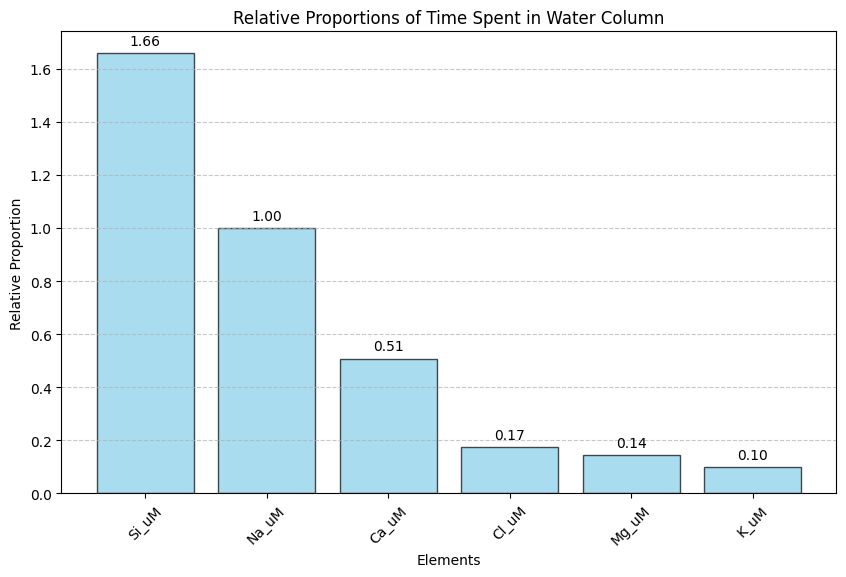

In [558]:
# Function to plot relative proportions
def plot_relative_proportions(df, elements, normalized_cols):
    # Prepare data
    relative_proportions = {element: [] for element in elements}

    for _, row in df.iterrows():
        for element in elements:
            normalized_col = f'{element}_time_normalized'
            if normalized_col in df.columns and not np.isnan(row.get(normalized_col, np.nan)):
                relative_proportions[element].append(row[normalized_col])

    # Calculate mean proportions for each element
    mean_proportions = {element: np.mean(values) for element, values in relative_proportions.items() if values}

    # Sort elements by mean proportions
    sorted_elements = sorted(mean_proportions, key=mean_proportions.get, reverse=True)
    sorted_mean_values = [mean_proportions[element] for element in sorted_elements]

    # Plot the distributions as a grouped bar chart
    x_positions = np.arange(len(sorted_elements))

    plt.figure(figsize=(10, 6))
    plt.bar(x_positions, sorted_mean_values, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xticks(x_positions, sorted_elements, rotation=45)
    plt.ylabel('Relative Proportion')
    plt.xlabel('Elements')
    plt.title('Relative Proportions of Time Spent in Water Column')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add mean values as text on top of bars
    for x, mean in zip(x_positions, sorted_mean_values):
        plt.text(x, mean + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=10)

    plt.show()

# Call the function to plot
plot_relative_proportions(df_copy, elements, time_normalized_columns)

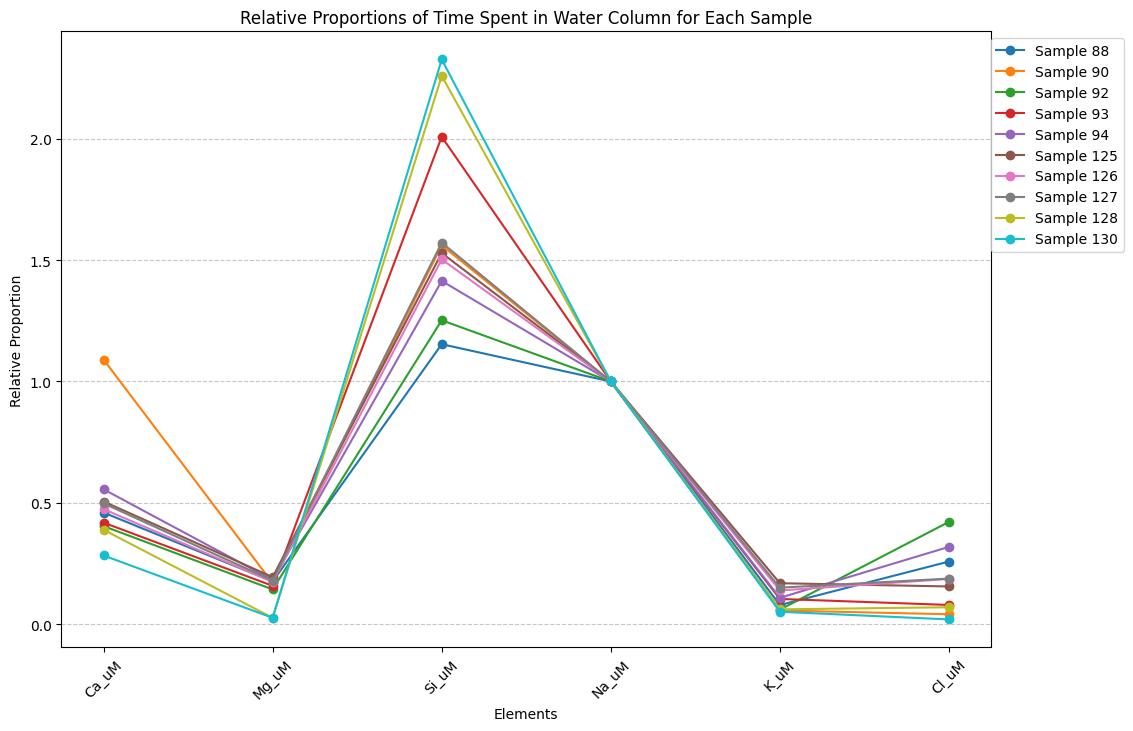

In [559]:
# Function to plot relative proportions for each sample
def plot_relative_proportions(df, elements, normalized_cols):
    plt.figure(figsize=(12, 8))
    
    for index, row in df.iterrows():
        sample_normalized = [row[col] for col in normalized_cols if col in df.columns and not np.isnan(row[col])]
        corresponding_elements = [element for element in elements if f'{element}_time_normalized' in df.columns]
        
        if sample_normalized:
            plt.plot(corresponding_elements[:len(sample_normalized)], sample_normalized, marker='o', linestyle='-', label=f'Sample {index}')
    
    plt.ylabel('Relative Proportion')
    plt.xlabel('Elements')
    plt.title('Relative Proportions of Time Spent in Water Column for Each Sample')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

# Call the function to plot
plot_relative_proportions(df_copy, elements, time_normalized_columns)


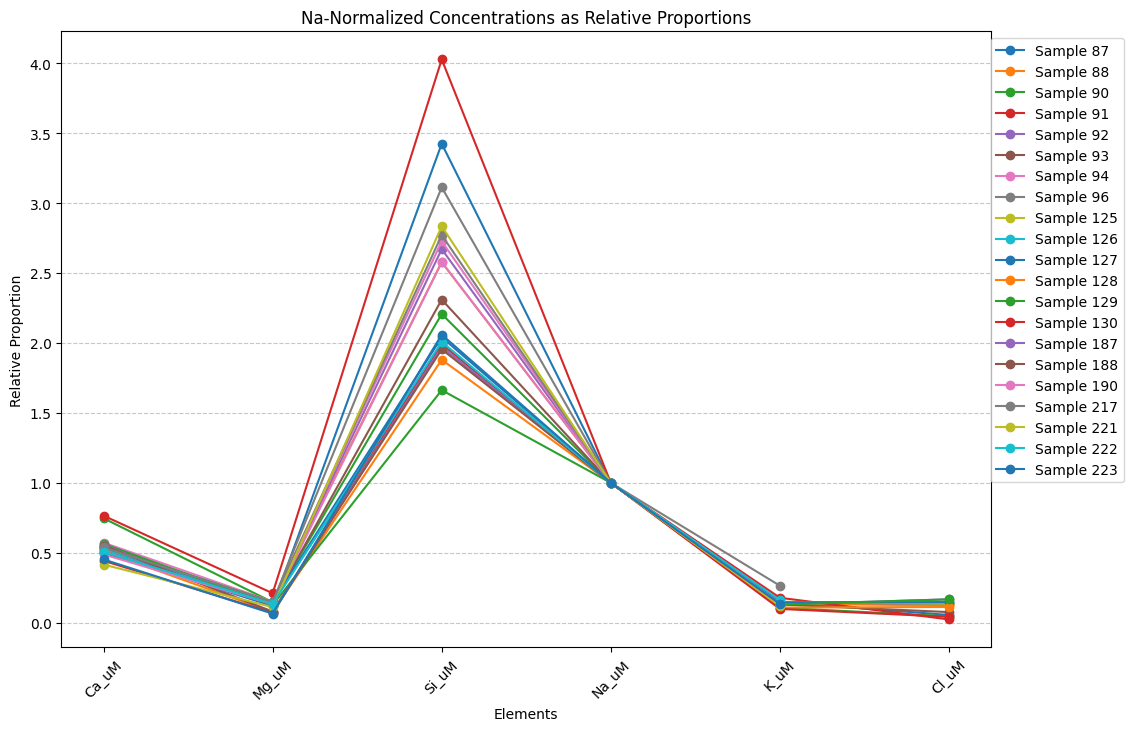

In [560]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot Na-normalized concentrations as relative proportions for each sample
def plot_na_normalized_concentrations(df, elements):
    plt.figure(figsize=(12, 8))
    
    for index, row in df.iterrows():
        na_concentration = row.get('Na_uM', np.nan)
        if not np.isnan(na_concentration) and na_concentration > 0:
            relative_concentrations = []
            for element in elements:
                concentration_col = f'{element}'
                if concentration_col in df.columns:
                    element_concentration = row.get(concentration_col, np.nan)
                    if not np.isnan(element_concentration):
                        relative_concentrations.append(element_concentration / na_concentration)
                    else:
                        relative_concentrations.append(np.nan)
                else:
                    relative_concentrations.append(np.nan)
            
            # Plot the relative concentrations for the current sample
            plt.plot(elements, relative_concentrations, marker='o', linestyle='-', label=f'Sample {index}')
    
    plt.ylabel('Relative Proportion')
    plt.xlabel('Elements')
    plt.title('Na-Normalized Concentrations as Relative Proportions')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

# Call the function to plot Na-normalized concentrations
plot_na_normalized_concentrations(df_copy, elements)


# River influence Hypothesis